### Imports

In [1]:
import os
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

### Helper Functions

In [3]:
def train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols):
    """ Trains RandomForestClassifiers/Regressors on Xtrain and ytrain_tremor and Xtrain and ytrain_bradykinesia.
    Then uses model to make predictions on each set in Xtest_sets, returning the mean and variance of the  results 
    of each Xtest set along with the results' identifying info as a dataframe """
    
    results = pd.DataFrame(data=test_set_info,columns= test_set_info_cols) # replace 'num_clips' with 'task' for some
    
    # train a random forest classifier/regressor
    # clf = RandomForestClassifier(n_estimators=50,random_state=2)
    clf = RandomForestRegressor(n_estimators=50,random_state=2)
    
    # fit classifier to the tremor training set
    clf.fit(Xtrain, ytrain_tremor)

    for i in range(len(Xtest_sets)): 
        # predictions for test set based on the trained model
        y_pred = clf.predict(Xtest_sets[i])
        y = y_pred.mean()
        v = y_pred.var()
        # update results
        results.loc[i, 'tremor score'] = y
        results.loc[i, 'ts_var'] = v
    
    # fit classifier to the bradykinesia training set
    clf.fit(Xtrain, ytrain_bradykinesia)
    
    for i in range(len(Xtest_sets)): # each test_set is a random sample of one file's features
        # predictions for test set based on the trained model
        y_pred = clf.predict(Xtest_sets[i])
        y = y_pred.mean()
        v = y_pred.var()
        # update results
        results.loc[i, 'bradykinesia score'] = y
        results.loc[i, 'bs_var'] = v
        
    return results


def LOSOCV(Data,X,y,groups,models,LOin=0):
    """ for each model type in models, for each group in Data, train a model of the specified type on the rest of the 
    groups and cross validate the results on the current group. Print the resulting statistics. Return the results,
    group results, and a dictionary containing subject-auroc pairings"""

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model


    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        subj_auroc_pairings = {}
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            dtr, dte = Data.iloc[train_index], Data.iloc[test_index]
            subj = dte.loc[dte.index[0], 'Subject']
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                print('only 1 class available in train data - skipping')
                continue
            # fit classifier to data
            clf.fit(Xtr,ytr)
            # predict based on model
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte) # WHAT DOES THIS DO???
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                print('only 1 class in test data - cannot compute roc curve')
                continue
                auroc = np.nan
            
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)
            
            #the recall per task - TO BE COMPLETED
            
#             tasks=Data.iloc[test_index,:].Task
#             for t in tasks.unique():
#                 tasks
            
            #compute ROC points at fixed fpr (to plot error bars)  # WHAT DOES THIS DO???
            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            print('Subject: '+ subj.__str__() + ' prec=%.3f, rec=%.3f, Spec=%.3f, auroc_train=%.3f, auroc=%.3f'%(precision_score(yte,ypred),recall_score(yte,ypred),
                                                                                 spec,auroc_train,auroc))
            s+=1
            subj_auroc_pairings[subj] = auroc
        print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
                        ,index=[0])
        results = pd.concat((results,r))
        
    return results,groupres, subj_auroc_pairings
    

# #train multiple classifiers using stratified kfold
# def trainmodel_Kfold(Xf,y,models,nfolds=5,balance=False):

#     scaler = StandardScaler()
#     f1_fold_clf=[]; auc_fold_clf=[]; cmats={}

#     skf = StratifiedKFold(n_splits=nfolds,shuffle=True,random_state=46)
        
#     for clf,model_name in models:
#         f1_fold = []; f1_train_fold=[]; prec_fold=[]; rec_fold=[]; auprc_fold=[]

#         for train_idx,test_idx in skf.split(Xf,y):
#             Xtr = Xf[train_idx]
#             ytr = y[train_idx]
#             if balance:
#                 #balance dataset
#                 indsp = np.where(ytr==1)[0]
#                 indsn = np.random.choice(np.where(ytr==0)[0],size=round(1*len(indsp)),replace=False)
#                 inds = np.hstack((indsp,indsn))
#                 Xtr = Xtr[inds]; ytr = ytr[inds]
# #             print(len(ytr[ytr==0])/len(ytr[ytr>0]))
#             Xte = Xf[test_idx]
#             yte = y[test_idx]
#             Xtr = scaler.fit_transform(Xtr)
#             Xte = scaler.transform(Xte)
#             clf.fit(Xtr,ytr)
#             ypred_train = clf.predict(Xtr)
#             ypred = clf.predict(Xte)
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]
            
#             #accuracy on train and test set for current fold
#             precision, recall, _ = precision_recall_curve(yte,yscore)
            
#             f1_train_fold.append(f1_score(ytr,ypred_train))
#             f1_fold.append(f1_score(yte,ypred))
#             prec_fold.append(precision_score(yte,ypred))
#             rec_fold.append(recall_score(yte,ypred))
#             auprc_fold.append(auc(recall,precision)
# )


#         #mean accuracy across folds
#         if balance:
#             print('Npos = %d, Nneg = %d'%(len(indsp),len(indsn)))
            
#         print('%s'%model_name)
#         print('f1_train=%.3f+/-%.3f, f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f'%(
#         np.nanmean(f1_train_fold),np.nanstd(f1_train_fold),
#         np.nanmean(f1_fold),np.nanstd(f1_fold),
#         np.nanmean(prec_fold),np.nanstd(prec_fold), np.nanmean(rec_fold),np.nanstd(rec_fold),
#         np.nanmean(auprc_fold),np.nanstd(auprc_fold)))
        
#         cf_matrix = confusion_matrix(yte, ypred)
#         print(cf_matrix)
#         #store f1 and auc for each fold and clf
#         f1_fold_clf.append(f1_fold)
#         auc_fold_clf.append(auprc_fold)
#         #store cmat for each clf (on last fold)
#         cmats.update({model_name:cf_matrix})
        
#     return f1_fold_clf, auc_fold_clf, cmats

    
    
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# #     print(cm)

#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)

#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt),
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")

#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

    

# def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
#     #plot mean ROC across subjects (need to add shaded conf interval)
#     tprmu = np.mean(np.asarray(tpr_all),axis=0)
#     tpr=np.asarray(tpr_all)
#     fpr=np.reshape(fpr,(1,-1))
#     tprmu=np.reshape(tprmu,(1,-1))
#     label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
#     if plotname=='Threshold':
#         ls = '-'
#     else:
#         ls='-'
#     if ax == None:
#         ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
#     else:
#         sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
#     lw = 3
    
#     ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#     ax.set_xlim([-0.05, 1.0])
#     ax.set_ylim([0.0, 1.05])
#     ax.set_xlabel('False Positive Rate',fontsize=16)
#     ax.set_ylabel('True Positive Rate',fontsize=16)
#     ax.legend(loc='lower right')
    
#     return ax

# def LOSOCV_Tasks(Data,X,y,groups,tasks,clf):

#     subj = LeaveOneGroupOut() 
#     results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
#     groupres = {} #results on each group for each task subset


#     #train multiple classifiers
#     for T in tasks:
#         acc_all=[]; acc_train=[] 
#         f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
#         auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]
          
#         s = 0
#         #LOSO CV for current classifier
#         for train_index, test_index in subj.split(X, y, groups):
#             task_inds = Data.Task.iloc[test_index]==T[0]
#             for Ti in T[1::]:
#                 task_inds = task_inds | (Data.Task.iloc[test_index]==Ti)
#             test_index = test_index[task_inds]
#             Xtr, Xte = X[train_index], X[test_index]
#             ytr, yte = y[train_index], y[test_index]
#             if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
#                 print('only 1 class available in train data - skipping')
#                 continue
#             clf.fit(Xtr,ytr)
#             ypred = clf.predict(Xte)
#             yscore = clf.predict_proba(Xte)
#             yscore = yscore[:,1]

#             #accuracy on train set
#             ypred_train = clf.predict(Xtr)
#             acc_train.append(sum(ypred_train==ytr)/len(ytr))
#             auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])

#             #f1-score, prec, recall, specificity, auprc, auroc
#             f1_test_all.append(f1_score(yte,ypred))
#             precision, recall, _ = precision_recall_curve(yte,yscore)
#             auprc = auc(recall,precision)
#             if len(np.unique(yte))>1:
#                 auroc = roc_auc_score(yte,yscore)
#             else:
#                 print('only 1 class in test data - cannot compute roc curve')
#                 auroc = np.nan
#             spec = sum((ypred==0) & (yte==0))/sum(yte==0)


#             prec_all.append(precision_score(yte,ypred))
#             rec_all.append(recall_score(yte,ypred))
#             auprc_all.append(auprc)
#             auroc_all.append(auroc)
#             auroc_train_all.append(auroc_train)
#             spec_all.append(spec)

#             #the recall per task - TO BE COMPLETED

# #             tasks=Data.iloc[test_index,:].Task
# #             for t in tasks.unique():
# #                 tasks

#             #compute ROC points at fixed fpr (to plot error bars)
#             fpr=np.linspace(0,1,101); tpr=[]

#             if len(np.unique(yte))>1:                
#                 nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
#                 neg_counts = sum(yte==0)
#                 for f in fpr:
#                     ind = neg_counts-int(neg_counts*f)-1
#                     t = (nscores[ind])[0]
#                     if f==1:
#                         t = 0
#                     tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
#                     tpr.append(tpr_t) 

#             fpr = np.asarray(fpr); tpr = np.asarray(tpr)
#             fpr_all.append(fpr); tpr_all.append(tpr)

#             #store feature importance
#             if model_name != 'SVM':
#                 fi_all.append(clf.feature_importances_)

#             s+=1

#         #group results for each model
#         groupres[tuple(T)] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
#                                 'rec':rec_all, 'spec':spec_all, 'fi':fi_all}

#         #mean across groups for each model
#         r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 'auroc':np.nanmean(auroc_all)}
#                         ,index=[0])
#         results = pd.concat((results,r))
        
#     return results,groupres 
    

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Leave One Subject Out Cross Validation on All Clinic Data

In [4]:
# ### ORGANIZING DATA - optional to exclude subjects who did not fit original model well ###
# os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/')
# Data = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
# Dataorig = Data.copy()
# # remove 1020
# l = [1020]
# # exclude subjects who did not fit original models for Tremor or Bradykinesia
# # l = [1005, 1044, 1023, 1039, 1043, 1048, 1049, 1009, 1038, 1003, 1046, 1019, 1032, 1020]
# # exclude subjects who did not fit original model for Tremor
# # l = [1039, 1044, 1048, 1046, 1009, 1043, 1005] #, 1020] # optional exclude subj 1020 also
# # include all subjects
# # l = []
# Data=Data.loc[~Data.Subject.isin(l)]
# Dataorig = Data.copy()
# # sanity check
# sns.distplot(Data.PSD_skew)

### Bradykinesia - HP filtered features 

In [5]:
# t1=time.time()
# res_all = pd.DataFrame()

# Data=Data.reset_index(drop=True) #reset index

# for symptom in ['Bradykinesia']:
    
#     #remove nan rows for current symptom
#     Data = Dataorig.copy() #original unmodified dataframe  ###MAKE SURE THIS IS CORRECT
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index
    
#     X = Data.iloc[:,5:].as_matrix()
#     # X = StandardScaler().fit_transform(X)
#     fnames = Data.iloc[:,7:].columns.values

#     indp = ((Data[symptom]>0))
#     indp = indp.values
#     y = indp.astype(int) #target 
#     print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

#     models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
# #           XGBClassifier()]
#     model_name = ['Random Forest']#,'XGB']
#     models = list(zip(models,model_name))
#     groups = Data.Subject.as_matrix()

#     res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
#     for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
#         print ("%s: %s" % (key, value))
#     res_all = pd.concat((res_all,res))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

# sns.barplot(x=Data.Subject.unique(),y=res_group['Random Forest']['auroc'])
# plt.ylim([0.45,1])

### Tremor - HP filtered features 

In [6]:
# t1=time.time()
# res_all = pd.DataFrame()

# Data=Data.reset_index(drop=True) #reset index

# for symptom in ['Tremor']: ##changed
    
#     #remove nan rows for current symptom
#     Data = Dataorig.copy() #original unmodified dataframe
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index
    
#     X = Data.iloc[:,5:].as_matrix()
#     # X = StandardScaler().fit_transform(X)
#     fnames = Data.iloc[:,7:].columns.values

#     indp = ((Data[symptom]>0))
#     indp = indp.values
#     y = indp.astype(int) #target 
#     print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

#     models = [RandomForestClassifier(n_estimators=50,random_state=2)]          
#     model_name = ['Random Forest']
#     models = list(zip(models,model_name))
#     groups = Data.Subject.as_matrix()

#     res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
#     for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
#         print ("%s: %s" % (key, value))
#     res_all = pd.concat((res_all,res))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training Model on Clinic Data

In [7]:
# ### SETUP TRAINING DATA (from clicic visits) ###

# # get all data and remove useless rows
# Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
# Xtrain = Xtrain[Xtrain.Subject!=1020]
# Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
# Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
# Xtrain = Xtrain.reset_index(drop=True)
# # get tremor training target
# # indp = ((Xtrain['Tremor']>0))
# indp = Xtrain['Tremor']
# indp = indp.values
# ytrain_tremor = indp.astype(int)
# # get bradykinesia training target
# # indp = ((Xtrain['Bradykinesia']>0))
# indp = Xtrain['Bradykinesia']
# indp = indp.values
# ytrain_bradykinesia = indp.astype(int)
# # get the training data set
# Xtrain = Xtrain.iloc[:,5:].as_matrix()

### Testing Model on All Home Data

In [8]:
# ### SETUP TEST DATA (from home data) ###

# # get all data
# Xtest_sets = []
# test_set_info = []
# test_set_info_cols = ['subj', 'date', 'MDS score']
# home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features/')
# for name in home_feature_files:
#     if "features" not in name:
#         home_feature_files.remove(name)
# summary_info = pd.read_csv('X:\CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in home_feature_files:
#     user = int(file[9:15])
#     date = dt.datetime.strptime(file[16:26], "%Y-%m-%d")
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features//' + file)
#     Xtest = Xtest.iloc[:, 2:]
#     # Xtest = Xtest.sample(frac = 0.2)
#     num_clips = len(Xtest.index)
#     test_set_info.append([user, date, MDS_score])
#     Xtest_sets.append(Xtest.as_matrix())

In [9]:
# ### RUN TRAINING ALGORITHM ###
# df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
# correlations = df.corr(method = 'pearson')
# correlations.style

In [10]:
# df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)

In [11]:
# # examine correlations for each subject
# subjects = df.subj.unique()
# for s in subjects:
#     df1 = df[df.subj == s]
#     if (len(df1.index) < 4):
#         continue
#     correlations = df1.corr(method = 'pearson')
#     print("\n\n\nSubject " + s.__str__() + " all data correlation\n" + len(df1.index).__str__() + " samples\n")
#     print(correlations.loc['MDS score', ['tremor score', 'bradykinesia score']])
    

### Testing Model on Home Data - Walking Only

In [12]:
# ### SET UP TEST DATA - Walking Only ###
# # get all data
# Xtest_sets = []
# test_set_info = []
# test_set_info_cols = ['subj', 'date', 'MDS score']

# home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
# for name in home_feature_files:
#     if "features" not in name:
#         home_feature_files.remove(name)
# summary_info = pd.read_csv('X:\CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in home_feature_files:
#     user = int(file[14:20])
#     date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
#     trial = int(file[21:22])
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
#     Xtest = Xtest.loc[Xtest.Gait != 0]
#     Xtest = Xtest.iloc[:, 2:-3]
#     num_clips = len(Xtest.index)
#     if(num_clips == 0):
#         continue
#     test_set_info.append([user, date, MDS_score])
#     Xtest_sets.append(Xtest.as_matrix())

In [13]:
# ### RUN TRAINING ALGORITHM ###
# df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
# correlations = df.corr(method = 'pearson')
# correlations.style

In [14]:
# df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 10, reduce_C_function = np.mean)

### Testing Model on Home Data - Non-Walking Only

In [15]:
# ### SET UP TEST DATA - Non-Walking Only ###
# # get all data
# Xtest_sets = []
# test_set_info = []
# test_set_info_cols = ['subj', 'date', 'MDS score']
# home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
# for name in home_feature_files:
#     if "features" not in name:
#         home_feature_files.remove(name)
# summary_info = pd.read_csv('X:\CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in home_feature_files:
#     user = int(file[14:20])
#     date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
#     Xtest = Xtest.loc[Xtest.Gait == 0]
#     Xtest = Xtest.iloc[:, 2:-3]
#     num_clips = len(Xtest.index)
#     if(num_clips == 0):
#         continue
#     test_set_info.append([user, date, MDS_score])
#     Xtest_sets.append(Xtest.as_matrix())

In [16]:
# ### RUN TRAINING ALGORITHM ###
# df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
# correlations = df.corr(method = 'pearson')
# correlations.style

In [17]:
# df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 15, reduce_C_function = np.mean)

### Testing Model on Task Data

In [18]:
# ### SET UP TEST DATA ###
# # get all data
# Xtest_sets = []
# test_set_info = []
# test_set_info_cols = ['subj', 'date', 'MDS score']

# task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')

# summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study//subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in task_feature_files:
#     user = int(file[0:6])
#     date = dt.datetime.strptime(file[7:17], "%Y-%m-%d")
#     trial = int(file[-5:-4])
#     task = file[18:-6]
#     if (task != 'Wlkg'):
#         continue
#     # optional skip sessions based on trial number
#     #if (trial not in [5]):
#     #    continue
#     # note: scores for repeat-visits on same day may be misleading because of medication differences; are there separate MDS scores for these visits?
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + file)
#     Xtest = Xtest.iloc[:, 0:-6]
#     # num_clips = len(Xtest.index)
#     # if(num_clips == 0):
#     #     continue
    
#     test_set_info.append([user, date, MDS_score])
#     Xtest_sets.append(Xtest.as_matrix())

In [19]:
# ### RUN TRAINING ALGORITHM ###
# df = train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols)
# correlations = df.corr(method = 'pearson')
# correlations.style

In [20]:
# df.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', gridsize = 10)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training and Testing Model on Task Data

In [21]:
# """ Repeatedly train a model on 80% of the task data and test it on the remaining 20%, storing the results in 
#     the results list """

# results = []

# summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

# subjs = []
# task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
# test_set_info_cols = ['subj', 'date', 'MDS score', 'task']

# for file in task_feature_files:
#     s = int(file[0:6])
#     if s not in subjs:
#         subjs.append(s)

# for c in range(5):
#     num_subjs = len(subjs) * 0.2        
#     subjs_left_out = np.random.choice(a = subjs, size = int(num_subjs), replace = False)
    
#     Xtrain = pd.DataFrame()
#     Xtest_sets = []
#     test_set_info = []

#     for file in task_feature_files:
#         s = int(file[0:6])
#         features_to_add = pd.read_pickle("//FS2.smpp.local//RTO//CIS-PD Study\MJFF Curation\TaskFeatures\\" + file)
#         if s not in subjs_left_out:
#             Xtrain = Xtrain.append(features_to_add, ignore_index = True)
#         else:
#             date = dt.datetime.strptime(file[7:17], "%Y-%m-%d")
#             task = file[18:-6]
#             trial = int(file[7:8])
#             try:
#                 MDS_score = int(summary_info.loc[(summary_info.trial == trial) & (summary_info["6_digit_id"] == s), 'MDS_score'])
#             except:
#                 MDS_score = float('Nan')
                
#             # TODO: ADD TASK SCORES TO TEST_SET_INFO AND TEST_SET_INFO_COLS    
                
                
#             Xtest = features_to_add.iloc[:, 0:-6]
#             Xtest_sets.append(Xtest.as_matrix())
#             num_clips = len(Xtest.index)
#             test_set_info.append([s, date, MDS_score, task])

#     Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
#     Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]
#     Xtrain = Xtrain.reset_index(drop=True)
#     # get tremor training target
#     # indp = ((Xtrain['Tremor']>0))
#     indp = Xtrain['Tremor']
#     indp = indp.values
#     ytrain_tremor = indp.astype(int)
#     # get bradykinesia training target
#     # indp = ((Xtrain['Bradykinesia']>0))
#     indp = Xtrain['Bradykinesia']
#     indp = indp.values
#     ytrain_bradykinesia = indp.astype(int)
#     # get the training data set
#     Xtrain = Xtrain.iloc[:,0:-6].as_matrix()
    
#     results.append(train_and_predict_separate_sets(Xtrain, ytrain_tremor, ytrain_bradykinesia, Xtest_sets, test_set_info, test_set_info_cols))

In [22]:
# """ for each task, find the mean and variance of the correlations between the MDS-UPDRS scores and the tremor score 
#     and the MDS-UPDRS scores and the bradykinesia scores from all of the randomly grouped models. Print only the results
#     where the mean correlation between the MDS score and the tremor or bradykinesia score is greater than 0.25 """

# tasks = results[0].task.unique()
# bs_task_dict = {key: [] for key in tasks}
# ts_task_dict = {key: [] for key in tasks}
# for df in results:
#     for t in df.task.unique():
#         dft = df[df.task == t]
#         # print(t + ': ' + len(dft.index).__str__() + ' entries \n')
#         ts_mds_corr = dft.corr(method = 'pearson').loc['MDS score']['tremor score']            
#         bs_mds_corr = dft.corr(method = 'pearson').loc['MDS score']['bradykinesia score']
#         bs_task_dict[t].append(bs_mds_corr)
#         ts_task_dict[t].append(ts_mds_corr)

# most_correlated_tasks = []
# for t in tasks:
#     bm = np.mean(bs_task_dict[t])
#     bv = np.var(bs_task_dict[t])
#     tm = np.mean(ts_task_dict[t])
#     tv = np.var(ts_task_dict[t])
#     if ((bm >= 0.25) or (tm >= 0.25)): # print only significant results
#         print('\n' + t + ' results:\n')
#         most_correlated_tasks.append(t)
#         if (bm >= 0.25):
#             print('bradykinesia-mds | mean corr: ' + bm.__str__() + ' | var: ' + bv.__str__() + '\n' )
#         if (tm >= 0.25):
#             print('tremor-mds | mean corr: ' + tm.__str__() + ' | var: ' + tv.__str__() + '\n' )

In [23]:
# """ Make a hexbin plot of the model's predicted bradykinesia score vs the model's predicted Tremor Score 
#     where the darkeness of the bin corresponds to the MDS_UPDRS score """

# df_combined = pd.DataFrame()
# for df in results:
#     df_combined = df_combined.append(df, ignore_index = True)
    
# print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))

In [24]:
# """ for each task, make a box plot of the correlation between the MDS score and the model's predicted Tremor Score """

# labels = ts_task_dict.keys()
# values = []
# for l in labels:
#     values.append(ts_task_dict[l])
    
    

# plt.boxplot(x = values, labels = labels, vert = False)
# plt.figure()
# plt.show()
    

In [25]:
# """ Only including the tasks that are the strongest correlated with the MDS score, make a hexbin plot of the model's 
#     predicted bradykinesia score vs the model's predicted Tremor Score where the darkeness of the bin corresponds to 
#     the MDS_UPDRS score """

# df_combined = pd.DataFrame()
# for df in results:
#     df_combined = df_combined.append(df, ignore_index = True)
    
# df_combined = df_combined.loc[df_combined.task.isin(most_correlated_tasks)]
    
# print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))
# print("\n\n tasks included: " + most_correlated_tasks.__str__())

In [26]:
# """ Only including walking and walking while counting tasks, make a hexbin plot of the model's 
#     predicted bradykinesia score vs the model's predicted Tremor Score where the darkeness of the bin corresponds to 
#     the MDS_UPDRS score """

# df_combined = pd.DataFrame()
# for df in results:
#     df_combined = df_combined.append(df, ignore_index = True)

# tasks_to_include = ['Wlkg', 'WlkgCnt']
# df_combined = df_combined.loc[df_combined.task.isin(tasks_to_include)]
    
# print(df_combined.plot.hexbin(x = 'tremor score', y = 'bradykinesia score', C = 'MDS score', reduce_C_function = np.mean, gridsize = 15))
# print("\n\n tasks included: " + tasks_to_include.__str__())

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training and Testing Model on Task Data - LOSOCV

In [27]:
# """ trying to determine if the same subjects fit the model poorly as in original model cross-validation, using
#     auroc as a measure of how well the subject fits the model """

# ### organize data
# task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
# Data = pd.DataFrame()
# for f in task_feature_files:
#     # Exclude subjects who did not fit original models for Tremor and Bradykinesia
#     # l = ['142561', '142618', '142622', '142612', '142608', '142578', '142563', '142577', '142560', '142585', '142581', '142583', '142593', '142575']
#        # Exclude subjects who did not fit original model for Tremor
#     # l = ['142622', '142575', '142608', '142585', '142563', '142612', '142561'] #, '142593']  # subj 1020=142561 optional at end
#     l = [] # Include all subjects
#     if f[:6] not in l:
#         if(Data.empty):
#             Data = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
#         else:
#             d = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f)
#             Data = Data.append(d, ignore_index = True)
# Data = Data[~Data['Tremor'].isnull()]
# Data = Data[~Data['Bradykinesia'].isnull()]
# np.sort(Data.Subject.unique())
# # remove 1020
# Data=Data[Data.Subject!=1020]
# Dataorig = Data.copy()
# # sanity check
# sns.distplot(Data.PSD_skew)

In [28]:
# """ Run a leave-one-subject-out cross validation for each subject on a model trained with all the other 
#     subjects' task data to predict the Bradykinesia score. """

# t1=time.time()
# res_all = pd.DataFrame()

# Data = Dataorig.copy()
# Data=Data.reset_index(drop=True) #reset index


# for symptom in ['Bradykinesia']:
    
#     #remove nan rows for current symptom
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index
        
    
#     X = Data.iloc[:,0:-6].as_matrix()
#     # X = StandardScaler().fit_transform(X)
#     fnames = Data.iloc[:,0:-6].columns.values

#     indp = ((Data[symptom]>0))
#     indp = indp.values
#     y = indp.astype(int) #target 
#     print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

#     models = [RandomForestClassifier(n_estimators=50,random_state=2)]          

#     model_name = ['Random Forest']
#     models = list(zip(models,model_name))
#     groups = Data.Subject.as_matrix()

#     res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
#     print("\nSorted auroc for each subject:\n")
#     for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
#         print ("%s: %s" % (key, value))
#     res_all = pd.concat((res_all,res))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

In [29]:
# """ Run a leave-one-subject-out cross validation for each subject on a model trained with all the other 
#     subjects' task data to predict the Tremor score. """

# t1=time.time()
# res_all = pd.DataFrame()

# Data = Dataorig.copy()
# Data=Data.reset_index(drop=True) #reset index

# for symptom in ['Tremor']:
    
#     #remove nan rows for current symptom
#     Data=Data[~Data[symptom].isnull()]
#     Data=Data.reset_index(drop=True) #reset index
    
#     X = Data.iloc[:,0:-6].as_matrix()
#     # X = StandardScaler().fit_transform(X)
#     fnames = Data.iloc[:,0:-6].columns.values

#     indp = ((Data[symptom]>0))
#     indp = indp.values
#     y = indp.astype(int) #target 
#     print('Rows w %s %d/%d = %.2f'%(symptom,sum(indp),len(indp),(sum(indp)/len(indp))))

#     models = [RandomForestClassifier(n_estimators=50,random_state=2)]          

#     model_name = ['Random Forest']
#     models = list(zip(models,model_name))
#     groups = Data.Subject.as_matrix()

#     res,res_group,subj_auroc_pairings = LOSOCV(Data,X,y,groups,models)
#     print("\nSorted auroc for each subject:\n")
#     for key, value in sorted(subj_auroc_pairings.items(), key= lambda item : (item[1], item[0])):
#         print ("%s: %s" % (key, value))
#     res_all = pd.concat((res_all,res))
    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))   

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training Model on Walking & Walking+Counting Task Data

In [30]:
# """ train a model to predict the tremor score on the data from the walking and walking while counting tasks """

# t1=time.time()

# # Training Model
# Data = Dataorig.copy()
# Data=Data.reset_index(drop=True) #reset index
# summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# Data=Data.reset_index(drop=True)
# for index, row in Data.iterrows():
#     if (row['Visit'] == '4 Weeks'):
#         Data.loc[index, 'Visit'] = '1 Month'
# Data=Data.reset_index(drop=True)
# Data.head()

# for index, row in Data.iterrows(): 
#     try:
#         Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
#     except:
#         Data.loc[index, 'MDS score'] = float('Nan')
        
# #remove nan rows 
# Data=Data[~Data['MDS score'].isnull()]
# Data=Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')]
# Data=Data.reset_index(drop=True) #reset index
# Data.head()
# Data.Tremor.unique()

# Xtrain = Data.iloc[:,0:-7].as_matrix()



# indp = Data['Tremor']
# indp = indp.values
# ytrain = indp.astype(int) #target 
    
# clf = RandomForestRegressor(n_estimators=50,random_state=2)
# clf.fit(Xtrain, ytrain)

In [31]:
# """ test the model on the home walking data """

# # Testing Model
# results = [] 
# # get all data
# home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
# for name in home_feature_files:
#     if "features" not in name:
#         home_feature_files.remove(name)
# summary_info = pd.read_csv('X:\CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in home_feature_files:
#     user = int(file[14:20])
#     date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
#     trial = int(file[21:22])
#     MDS_score = 0
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
#     Xtest = Xtest.loc[Xtest.Gait != 0]
#     Xtest = Xtest.iloc[:, 2:-3]

#     if(Xtest.empty):
#         continue
    
#     Xtest = Xtest.as_matrix()
    
    
#     y_pred = clf.predict(Xtest)
#     y = y_pred.mean()
#     results.append([MDS_score, y])

# results = pd.DataFrame(data = results, columns = ['MDS score', 'predicted tremor score'])


    
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))

In [32]:
# results.corr(method = 'pearson')

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Training  Model on Walking & Walking+Counting Task Data directly predicting MDS score

In [33]:
# """ Train a model to directly predict the MDS score on the walking and walking while counting data """

# t1=time.time()

# # Training Model
# Data = Dataorig.copy()
# Data=Data.reset_index(drop=True) #reset index
# summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# Data=Data.reset_index(drop=True)
# for index, row in Data.iterrows():
#     if (row['Visit'] == '4 Weeks'):
#         Data.loc[index, 'Visit'] = '1 Month'
# Data=Data.reset_index(drop=True)
# Data.head()

# for index, row in Data.iterrows(): 
#     try:
#         Data.loc[index, 'MDS score'] = int(summary_info.loc[(summary_info.VisitNm == row['Visit']) & (summary_info["SubjectCode"] == row['Subject']), 'MDS_score'])
#     except:
#         Data.loc[index, 'MDS score'] = float('Nan')
        
# #remove nan rows 
# Data=Data[~Data['MDS score'].isnull()]
# Data=Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')]
# Data=Data.reset_index(drop=True) #reset index

# Xtrain = Data.iloc[:,0:-7].as_matrix()
# indp = Data['MDS score']
# indp = indp.values
# ytrain = indp.astype(int) #target 
    
# clf = RandomForestRegressor(n_estimators=50,random_state=2)
# clf.fit(Xtrain, ytrain)

In [34]:
# """ test the model on the home walking data """

# # Testing Model
# results = [] 
# # get all data
# home_feature_files = os.listdir('//FS2.smpp.local/RTO/CIS-PD Study/Home WACC features + Gait/')
# for name in home_feature_files:
#     if "features" not in name:
#         home_feature_files.remove(name)
# summary_info = pd.read_csv('X:\CIS-PD Study\\subj visit summary info.csv', index_col = 0)
# summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])
# # get the testing data sets and the summary info about each testing set
# for file in home_feature_files:
#     user = int(file[14:20])
#     date = dt.datetime.strptime(file[21:31], "%Y-%m-%d")
#     trial = int(file[21:22])
#     MDS_score = 0
#     try:
#         MDS_score = int(summary_info.loc[(summary_info.FormDate == date) & (summary_info["6_digit_id"] == user), 'MDS_score'])
#     except:
#         MDS_score = float('Nan')
#     Xtest = pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//Home WACC features + Gait//' + file)
#     Xtest = Xtest.loc[Xtest.Gait != 0]
#     Xtest = Xtest.iloc[:, 2:-3]
#     if(Xtest.empty):
#         continue
#     Xtest = Xtest.as_matrix()
#     y_pred = clf.predict(Xtest)
#     y = y_pred.min() # generally probides better results than .mean(), .max() has strong negative corr indicating over estimating
#     results.append([MDS_score, y])

# results = pd.DataFrame(data = results, columns = ['MDS score', 'predicted y'])  
# print('Elapsed time = %.3f min'%((time.time()-t1)/60))

In [35]:
# results.corr(method = 'pearson')

In [36]:
# results.plot.hexbin(x = 'predicted y', y = 'MDS score', gridsize = 15)

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------

### Train Personal Models for each Subject on Task Data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142592
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.07032
corr coef bradykinesia predicted vs known: 0.09396236446110388


Subject: 142592 predicted tremor vs actual tremor



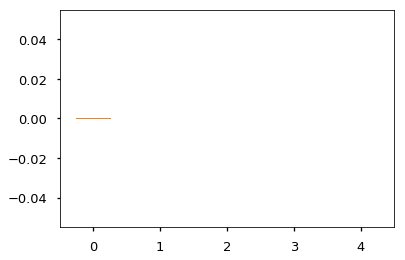

Subject: 142592 predicted bradykinesia vs actual bradykinesia



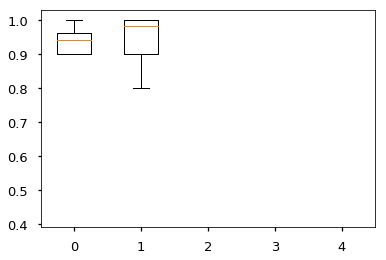

Subject: 142581
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142581 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


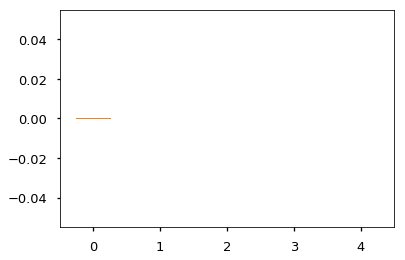

Subject: 142581 predicted bradykinesia vs actual bradykinesia



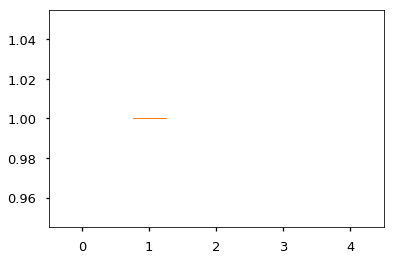

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142560
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.45380000000000004
corr coef bradykinesia predicted vs known: 0.8568572540231973


Subject: 142560 predicted tremor vs actual tremor



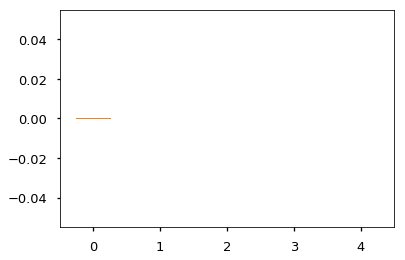

Subject: 142560 predicted bradykinesia vs actual bradykinesia



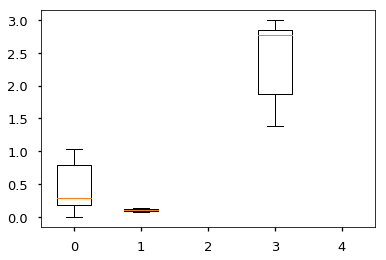

Subject: 142594
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.02821818181818182
corr coef bradykinesia predicted vs known: 0.9862489084893608


Subject: 142594 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


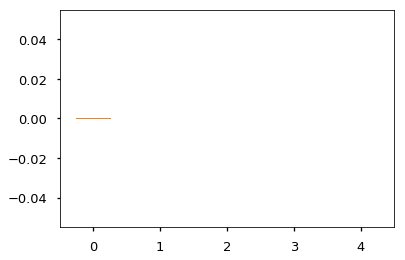

Subject: 142594 predicted bradykinesia vs actual bradykinesia



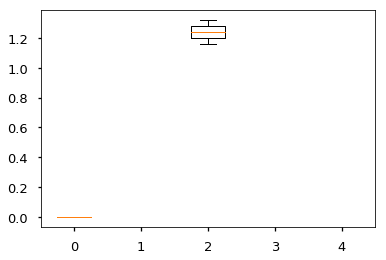

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142583
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.11425806451612901
corr coef bradykinesia predicted vs known: 0.6527761933064327


Subject: 142583 predicted tremor vs actual tremor



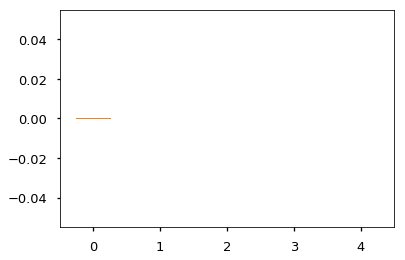

Subject: 142583 predicted bradykinesia vs actual bradykinesia



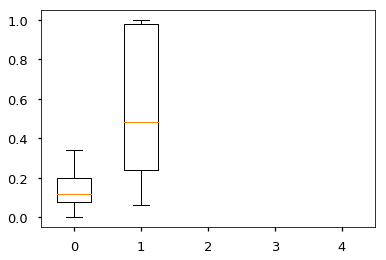

Subject: 142618
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0364
corr coef bradykinesia predicted vs known: 0.9711631658670145


Subject: 142618 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


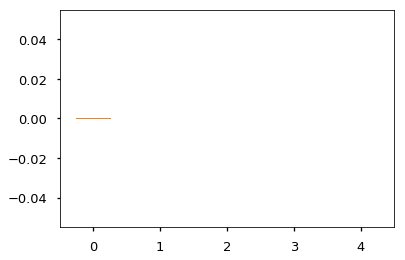

Subject: 142618 predicted bradykinesia vs actual bradykinesia



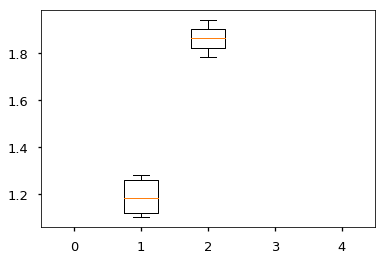

Subject: 142622
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.08656000000000004
corr coef bradykinesia predicted vs known: 0.8471758432101041


Subject: 142622 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


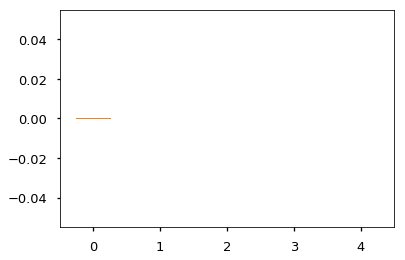

Subject: 142622 predicted bradykinesia vs actual bradykinesia



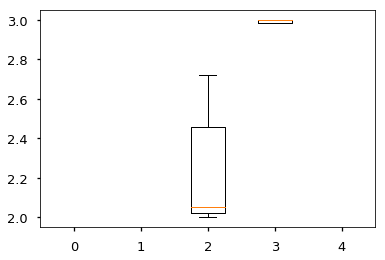

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142584
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.15555000000000002
corr coef bradykinesia predicted vs known: 0.8571837794548963


Subject: 142584 predicted tremor vs actual tremor



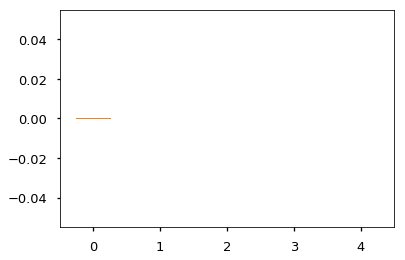

Subject: 142584 predicted bradykinesia vs actual bradykinesia



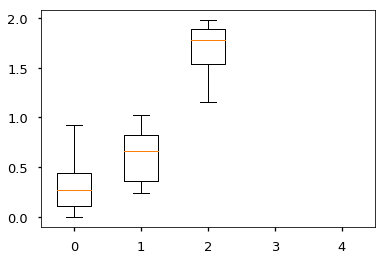

Subject: 142575
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142575 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


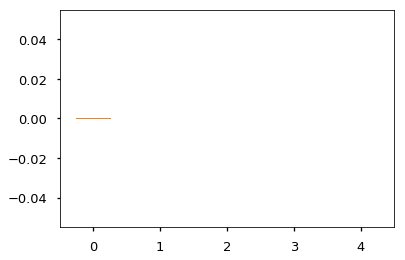

Subject: 142575 predicted bradykinesia vs actual bradykinesia



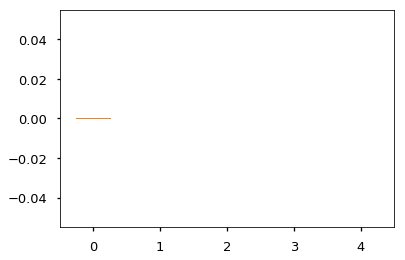

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142577
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142577 predicted tremor vs actual tremor



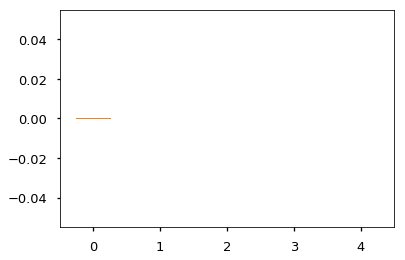

Subject: 142577 predicted bradykinesia vs actual bradykinesia



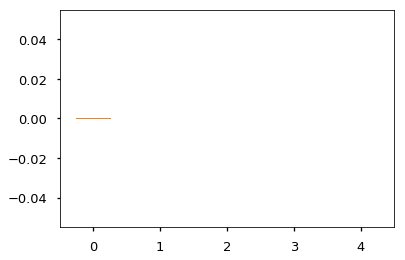

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142582
mean squared error tremor: 0.03466666666666666
corr coef tremor predicted vs known: 0.6735426299120415
mean squared error bradykinesia: 0.10559999999999999
corr coef bradykinesia predicted vs known: 0.5672700639311079


Subject: 142582 predicted tremor vs actual tremor



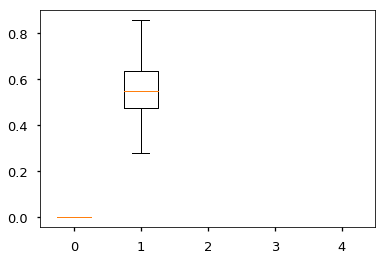

Subject: 142582 predicted bradykinesia vs actual bradykinesia



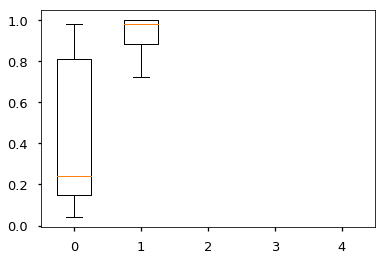

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142580
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142580 predicted tremor vs actual tremor



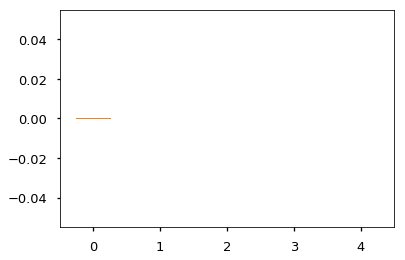

Subject: 142580 predicted bradykinesia vs actual bradykinesia



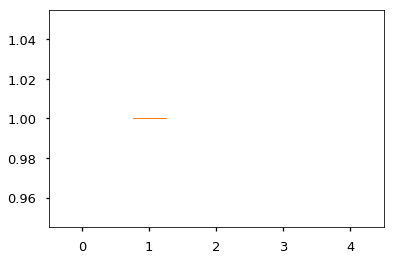

Subject: 142612
mean squared error tremor: 0.2499333333333333
corr coef tremor predicted vs known: 0.4041830574557374
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142612 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


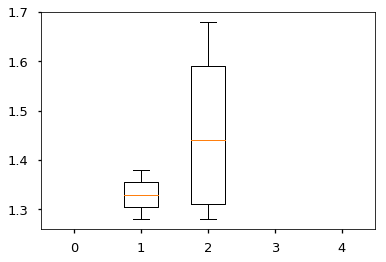

Subject: 142612 predicted bradykinesia vs actual bradykinesia



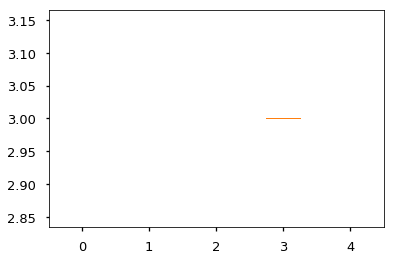

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Subject: 142563
mean squared error tremor: 0.5733957446808512
corr coef tremor predicted vs known: 0.42385272746302044
mean squared error bradykinesia: 0.1115659574468085
corr coef bradykinesia predicted vs known: 0.6506928392057597


Subject: 142563 predicted tremor vs actual tremor



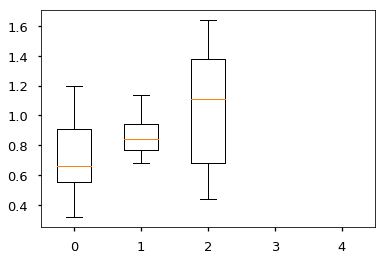

Subject: 142563 predicted bradykinesia vs actual bradykinesia



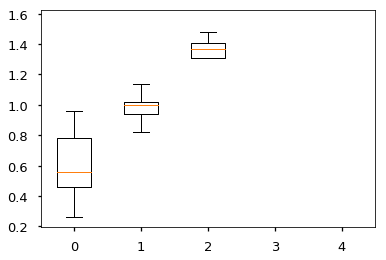

Subject: 142579
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.09384444444444445
corr coef bradykinesia predicted vs known: 0.7915912091553279


Subject: 142579 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


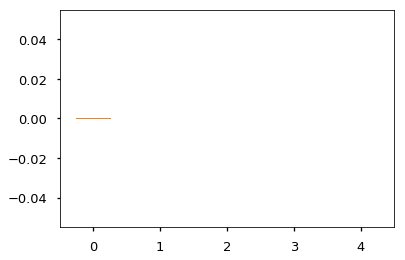

Subject: 142579 predicted bradykinesia vs actual bradykinesia



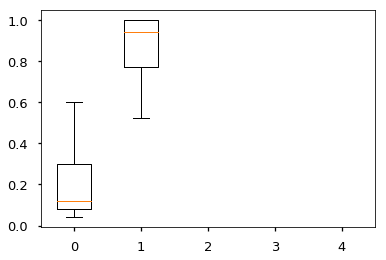

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


Subject: 142578
mean squared error tremor: 0.278304
corr coef tremor predicted vs known: 0.7784781270441253
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142578 predicted tremor vs actual tremor



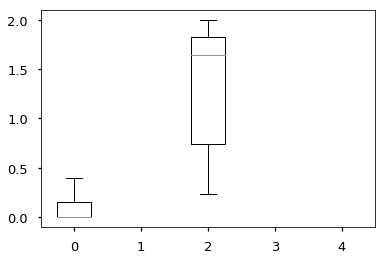

Subject: 142578 predicted bradykinesia vs actual bradykinesia



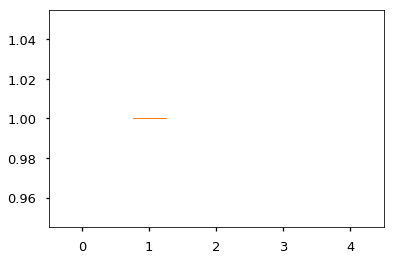

Subject: 142595
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.5055999999999999
corr coef bradykinesia predicted vs known: 0.8543384014420703


Subject: 142595 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


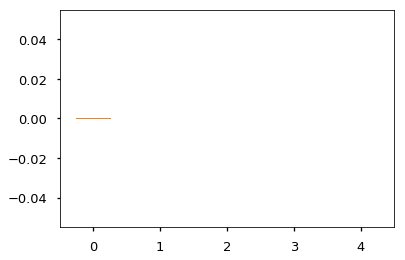

Subject: 142595 predicted bradykinesia vs actual bradykinesia



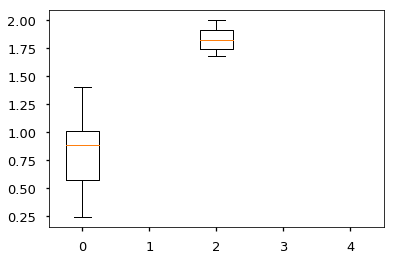

Subject: 142562
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142562 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


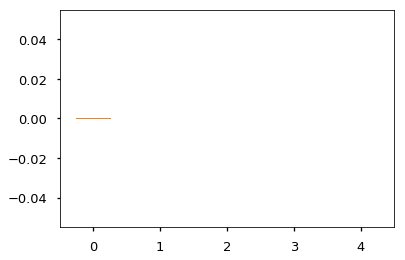

Subject: 142562 predicted bradykinesia vs actual bradykinesia



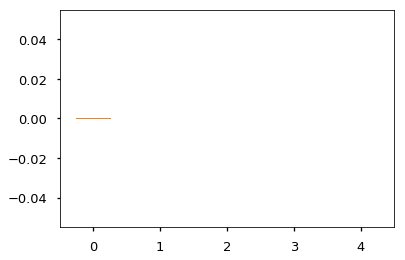

Subject: 142585
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142585 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


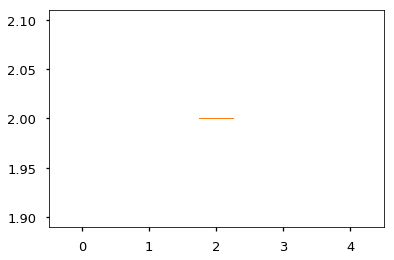

Subject: 142585 predicted bradykinesia vs actual bradykinesia



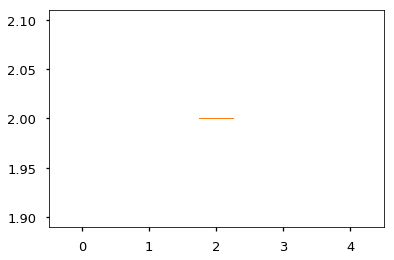

Subject: 142608
mean squared error tremor: 0.0
corr coef tremor predicted vs known: nan
mean squared error bradykinesia: 0.0
corr coef bradykinesia predicted vs known: nan


Subject: 142608 predicted tremor vs actual tremor



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


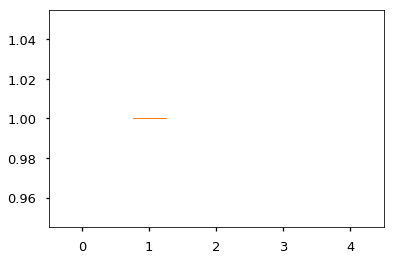

Subject: 142608 predicted bradykinesia vs actual bradykinesia



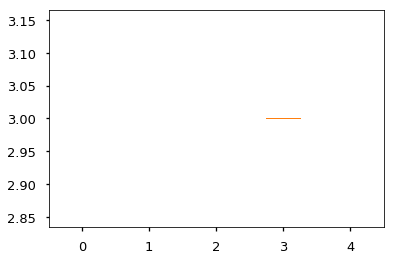

In [38]:
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
summary_info['FormDate'] = pd.to_datetime(summary_info['FormDate'])

subjs = []
task_feature_files = os.listdir('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//')
test_set_info_cols = ['subj', 'date', 'MDS score', 'task']

for file in task_feature_files:
    s = int(file[0:6])
    if s not in subjs:
        subjs.append(s)
        
subj_file_dict = {key: [] for key in subjs}
subj_trial_dict = {key:[] for key in subjs}
        
for file in task_feature_files:
    s = int(file[0:6])
    subj_file_dict[s].append(file)
    t = int(file[-5:-4])
    if t not in subj_trial_dict[s]:\
        subj_trial_dict[s].append(t)
    

for s in subjs:
    files = subj_file_dict[s]
    trials = subj_trial_dict[s]
    Data = pd.DataFrame()
    for f in files:
        Data = Data.append(pd.read_pickle('//FS2.smpp.local//RTO//CIS-PD Study//MJFF Curation//TaskFeatures//' + f), ignore_index = True)
    
    
    Data = Data[~Data['Tremor'].isnull()]
    Data = Data[~Data['Bradykinesia'].isnull()]
    # Data = Data[(Data.Task == 'Wlkg') | (Data.Task == 'WlkgCnt')] # optional only include walking data


    # remove 1020
    Data=Data[Data.Subject!=1020]
    Dataorig = Data.copy()
    
    # visits = ['4 Weeks', '2 Weeks: Time 90', '2 Weeks: Time 0', '2 Weeks: Time 150', '2 Weeks: Time 60', '2 Weeks: Time 30',
    #          '2 Weeks: Time 120']
    # if (len(visits)<2):
    #     continue
    # visit_left_out = ['4 Weeks', '2 Weeks: Time 60']# np.random.choice(a = visits, size = 1, replace = False)
    # Xtest = Data[Data.Visit.isin(visit_left_out)]
    # Xtrain = Data[~Data.Visit.isin(visit_left_out)]
    
    num = len(Data.index.values)
    if (num < 10):
        continue
    Xtest = Data.sample(frac = 0.3)
    indices_to_exclude = Xtest.index.values
    Xtrain = Data[~Data.index.isin(indices_to_exclude)]
    
    
    if (Xtest.empty or Xtrain.empty):
        continue
    
    ytrain_tremor = Xtrain['Tremor'].values
    ytrain_bradykinesia = Xtrain['Bradykinesia'].values
    
    ytest_tremor = Xtest['Tremor'].values
    ytest_bradykinesia = Xtest['Bradykinesia'].values
    
    Xtrain = Xtrain.iloc[:,0:-6].as_matrix()
    Xtest = Xtest.iloc[:, 0:-6].as_matrix()

    clf = RandomForestRegressor(n_estimators=50,random_state=2)
    
    clf.fit(Xtrain, ytrain_tremor)
    ypred_t = clf.predict(Xtest)
    # ypred_t = [int(round(y, 0)) for y in ypred_t]
    t_error = []
    for i in range(len(ypred_t)):
        t_error.append(math.pow(ytest_tremor[i] - ypred_t[i], 2))
    mean_squared_error_t = np.mean(t_error)
    corr_t = np.corrcoef(ytest_tremor, ypred_t)[0][1]
    
    clf.fit(Xtrain, ytrain_bradykinesia)
    ypred_b = clf.predict(Xtest)
    # ypred_b = [int(round(y, 0)) for y in ypred_b]
    b_error = []
    for i in range(len(ypred_b)):
        b_error.append(math.pow(ytest_bradykinesia[i] - ypred_b[i], 2))
    mean_squared_error_b = np.mean(b_error)
    corr_b = np.corrcoef(ytest_bradykinesia, ypred_b)[0][1]
    
    print("Subject: " + s.__str__() + "\nmean squared error tremor: " + mean_squared_error_t.__str__() + 
          "\ncorr coef tremor predicted vs known: " + corr_t.__str__() +
          "\nmean squared error bradykinesia: " + mean_squared_error_b.__str__() + 
          "\ncorr coef bradykinesia predicted vs known: " + corr_b.__str__() + "\n\n")
    
    t_predictions = [[],[],[],[],[]]
    b_predictions = [[],[],[],[],[]]
    for i in range(len(ypred_b)):
        t = int(ytest_tremor[i])
        b = int(ytest_bradykinesia[i])
        t_predictions[t].append(ypred_t[i])
        b_predictions[b].append(ypred_b[i])

    print('Subject: ' + s.__str__() + ' predicted tremor vs actual tremor\n')
    plt.boxplot(x = t_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()
    
    print('Subject: ' + s.__str__() + ' predicted bradykinesia vs actual bradykinesia\n')
    plt.boxplot(x = b_predictions, labels = ['0', '1', '2', '3', '4'])
    plt.show()
        
    
    

### ---------------------------------------------------------------------------------------------------------------------------------------------------------------